In [1]:
# Project: CrimesDelits
# Creation Date: 2023-10-11
# History:
######################################################################################################################################################
#   DATE            AUTHOR      VERSION     ACTION
#   2023-10-11      LLEG        1.0.0       Creation

import time
import logging
import warnings

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from utils.log_config import Logging
from utils.constant import Constant
from utils.functions import download_file, read_xlsx

c:\Users\clemj\OneDrive\Documents\M2_MIASHS\Clémentine\Projet\crimes-delits\utils\constant.py:27: SyntaxWarning: invalid escape sequence '\c'
  GEOJSON_FILE = 'data\contour-des-departements.geojson'


In [1]:
# load logging config
Logging.create_log_folder()
Logging.load_logging_config("./conf/logging.json")
log = logging.getLogger(__name__)

In [1]:
starting_time = time.time()
log.debug('Start')

In [1]:
download_file(url=Constant.DATA_URL, filepath=Constant.DATA_FILE)
download_file(url=Constant.DOCUMENTATION_URL, filepath=Constant.DOCUMENTATION_FILE)
download_file(url=Constant.INSTRUCTIONS_URL, filepath=Constant.INSTRUCTIONS_FILE)
download_file(url=Constant.GEOJSON_URL, filepath=Constant.GEOJSON_FILE)

[INFO] 2023-12-10 20:52:19,459 utils.functions.download_file() 34: crimes-delits.xlsx file already exists
[INFO] 2023-12-10 20:52:19,465 utils.functions.download_file() 34: documentation.docx file already exists
[INFO] 2023-12-10 20:52:19,470 utils.functions.download_file() 34: instructions.pdf file already exists
[INFO] 2023-12-10 20:52:19,472 utils.functions.download_file() 34: contour-des-departements.geojson file already exists


In [1]:
dict_df = read_xlsx(Constant.DATA_FILE)

In [1]:
# check for Na
na_sum = 0
for key in dict_df.keys():
    na_sum += dict_df[key].loc[Constant.CHOSEN_INDEX, :].sum().isna().sum()

print(f"NaN sum for {Constant.CHOSEN_INDEX}: {na_sum}")

NaN sum for [8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 39, 40]: 0


In [1]:
# create dataframe with groupby on departements and selecting chosen crime
df = pd.DataFrame({key: value.T.groupby(level='Départements').sum().T.loc[Constant.CHOSEN_INDEX].sum() for key, value in dict_df.items()}).T
df.columns.name = None
df.fillna(0, inplace=True)

df.insert(0, 'year', np.int_)
df.insert(1, 'services', np.int_)
df.insert(2, 'total', np.int_)

for index, row in df.iterrows():
    df.loc[index, 'year'] = index[-4:]
    df.loc[index, 'services'] = index[9:11]
    df.loc[index, 'total'] = row.drop(['year', 'services', 'total']).sum()
    
df.sort_values('year', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,year,services,total,01,02,03,04,05,06,07,...,95,971,972,973,974,976,978,986,987,988
0,2012,PN,331984.0,585.0,1235.0,807.0,552.0,278.0,10690.0,368.0,...,10785.0,2178.0,1761.0,1084.0,2199.0,1117.0,0.0,0.0,418.0,875.0
1,2012,GN,195935.0,3005.0,2438.0,722.0,852.0,346.0,2221.0,1435.0,...,2217.0,3439.0,2427.0,2265.0,1770.0,0.0,694.0,26.0,958.0,1003.0
2,2013,GN,204342.0,3495.0,2435.0,1006.0,757.0,408.0,2126.0,1377.0,...,2272.0,3602.0,2156.0,2612.0,1676.0,0.0,748.0,17.0,1027.0,1350.0
3,2013,PN,347022.0,686.0,1240.0,920.0,408.0,344.0,9945.0,460.0,...,10700.0,2369.0,1893.0,1405.0,2396.0,1322.0,0.0,0.0,327.0,959.0
4,2014,GN,195711.0,3500.0,2137.0,866.0,808.0,528.0,2209.0,1447.0,...,2388.0,3310.0,1771.0,2609.0,1762.0,0.0,618.0,16.0,944.0,1264.0
5,2014,PN,340821.0,598.0,1128.0,748.0,307.0,420.0,10681.0,462.0,...,10120.0,2278.0,1726.0,1524.0,2499.0,1342.0,0.0,0.0,404.0,814.0
6,2015,GN,190829.0,3671.0,2125.0,802.0,754.0,374.0,2464.0,1505.0,...,1952.0,3297.0,1409.0,2414.0,2292.0,0.0,644.0,27.0,985.0,1377.0
7,2015,PN,335547.0,567.0,1285.0,888.0,349.0,446.0,9169.0,389.0,...,9909.0,2446.0,1300.0,1936.0,2741.0,1698.0,0.0,0.0,498.0,1353.0
8,2016,PN,334067.0,685.0,999.0,995.0,355.0,395.0,8629.0,278.0,...,9828.0,2777.0,1562.0,2036.0,2785.0,1645.0,0.0,0.0,410.0,1303.0
9,2016,GN,193394.0,3646.0,2130.0,965.0,907.0,483.0,2333.0,1421.0,...,2025.0,2829.0,1411.0,2477.0,2327.0,0.0,351.0,14.0,1033.0,1507.0


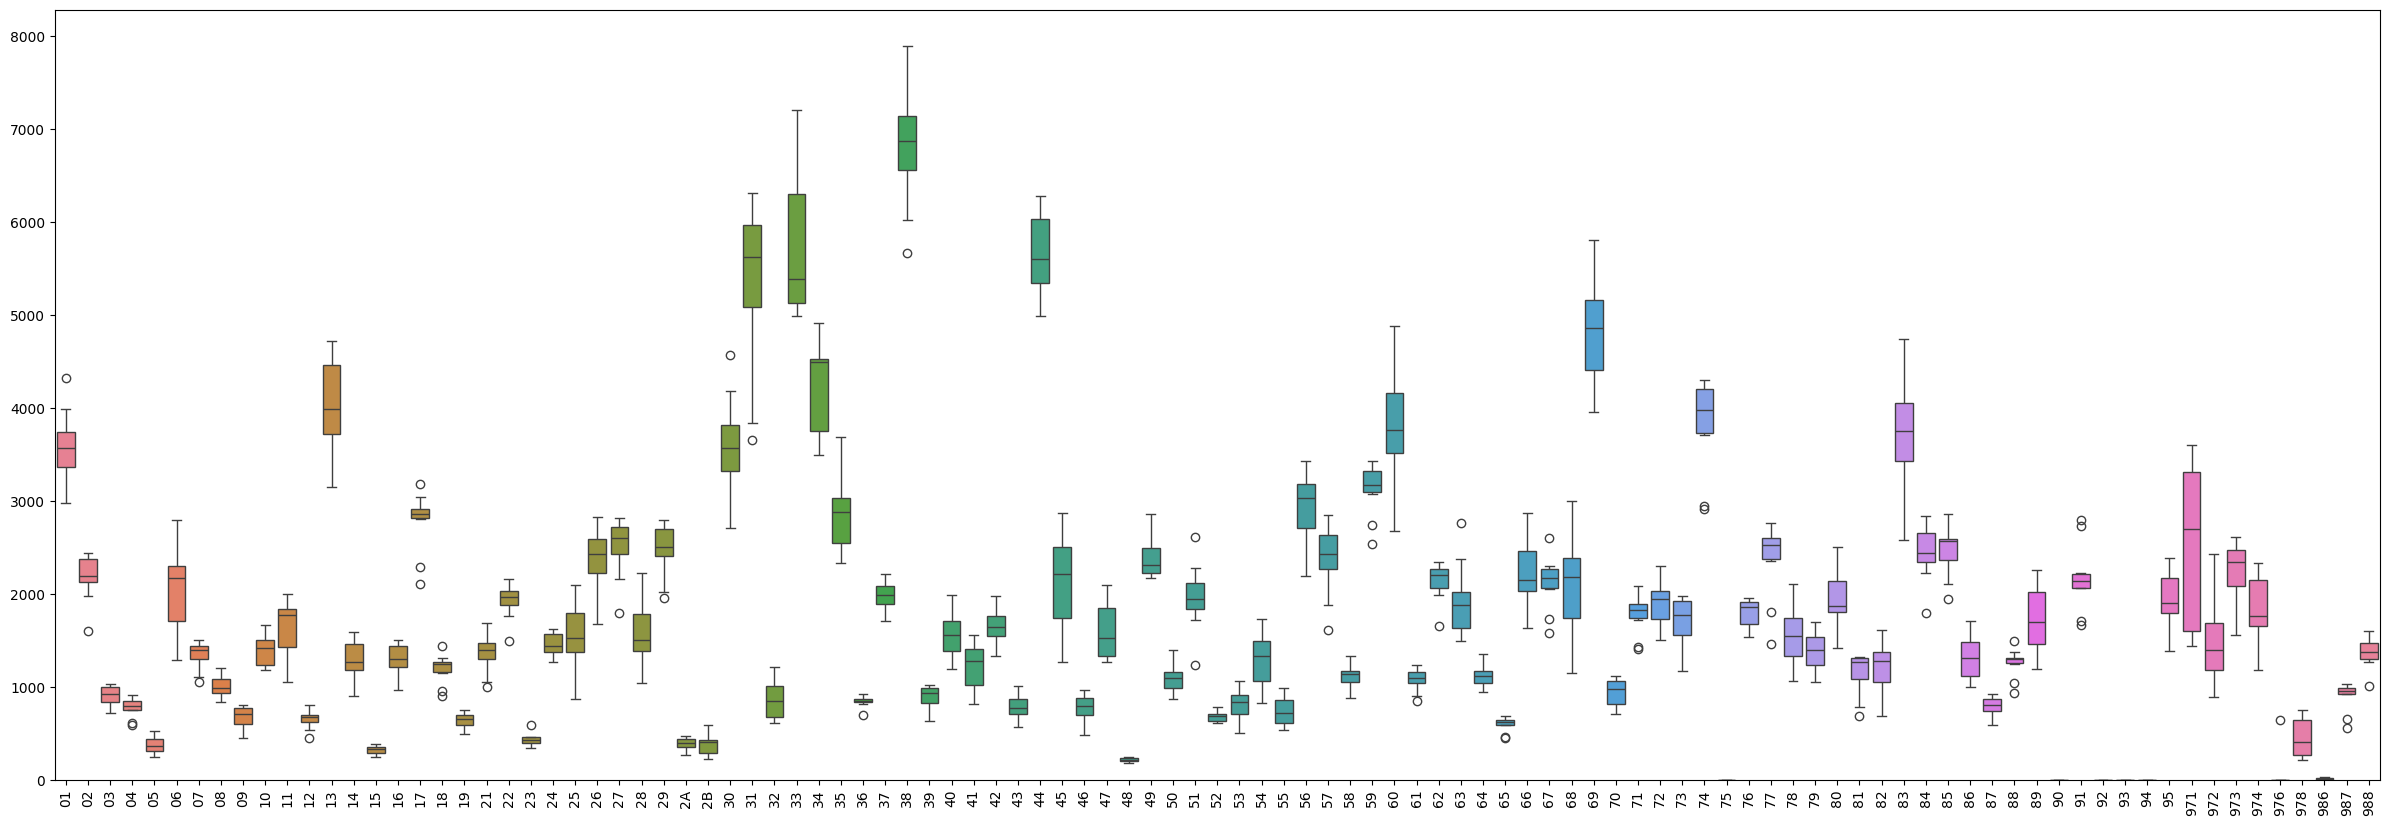

In [1]:
# plot boxplots of chosen service and crime
_, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df.drop(['year', 'total'], axis=1)[df['services'] == Constant.SERVICE])
plt.xticks(rotation=90)
ax.set(ylim=(0))
plt.show()

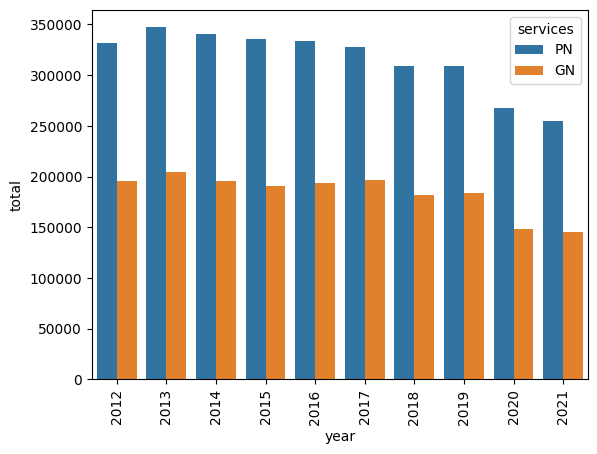

In [1]:
# plot total of index of choice by year
sns.barplot(data=df, x="year", y="total", hue="services", order=sorted(df["year"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
# Read file with geopandas
geo_df = gpd.read_file(Constant.GEOJSON_FILE)

# Plot PN 2012 heatmap
geo_df['Services PN 2012'] = np.int_
for index, row in geo_df.iterrows():
    geo_df.loc[index, 'Services PN 2012'] = round(df[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')][row['code']].iloc[0] / df.drop(['year', 'services', 'total'], axis=1)[(df['services'] == Constant.SERVICE) & (df['year'] == '2012')].max().max(), 3)

<Axes: >

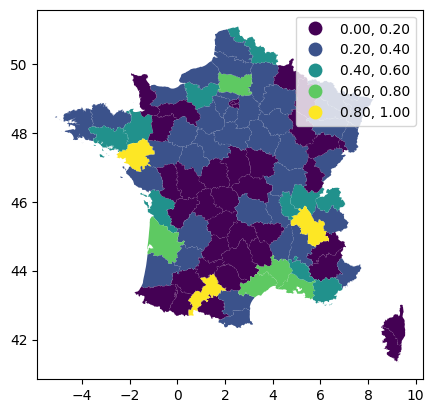

In [1]:
geo_df.plot(column='Services PN 2012', legend=True, scheme="prettybreaks")

In [1]:
df.rename(columns={'year': 'ds', 'total': 'y'}, inplace=True)

In [1]:
df_PN = df[df['services'] == Constant.SERVICE]

In [1]:
df_PN.index = pd.DatetimeIndex(df_PN.ds)
df_PN = df_PN.drop('ds', axis=1)

In [1]:
df_train = df_PN[df_PN.index < Constant.TRAIN_TEST_SPLIT_YEAR]
df_test = df_PN[df_PN.index >= Constant.TRAIN_TEST_SPLIT_YEAR]

In [1]:
warnings.filterwarnings("ignore")

[INFO] 2023-12-10 20:52:41,218 __main__.<module>() 63: AR RMSE: 20892.660013801054, AR R²: nan
[INFO] 2023-12-10 20:52:41,220 __main__.<module>() 64: ARIMA RMSE: 34233.38825129761, ARIMA R²: nan
[INFO] 2023-12-10 20:52:41,222 __main__.<module>() 65: SMA RMSE: 8594.535326388606, SMA R²: nan
[INFO] 2023-12-10 20:52:41,225 __main__.<module>() 66: EMA RMSE: 2039.7944130311953, EMA R²: nan
[INFO] 2023-12-10 20:52:41,228 __main__.<module>() 67: MLP RMSE: 3154.3656822410703, MLP R²: nan


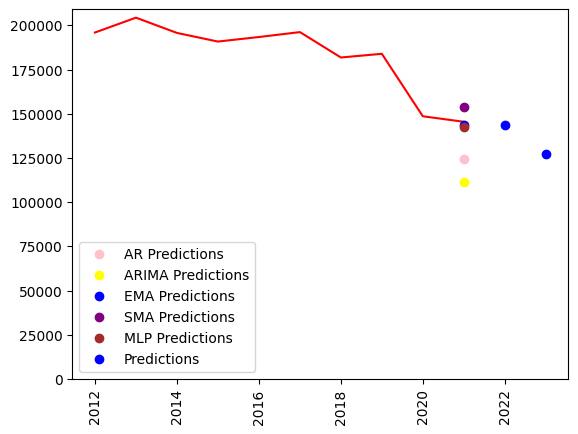

In [1]:
# plot existing data
plt.plot(df_PN.index,df_PN['y'],color='red')
#plt.plot(df_train.index, df_train['y'], color="black")
#plt.plot(df_test.index, df_test['y'], color="red")
plt.xticks(rotation=90)

y = df_train['y'].astype(int)
arima_model = ARIMA(y, order = (3, 2, 2))
arima_model = arima_model.fit()

# AR Model
ar_model = AutoReg(df_train['y'].astype(int), 1).fit()
y_pred_ar = ar_model.forecast(len(df_test))

# ARIMA Predictions
y_pred_arima = arima_model.get_forecast(len(df_test.index))
y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

# Simple Moving Average (SMA)
sma_model = SimpleExpSmoothing(df_train['y'].astype(int)).fit()
y_pred_sma = sma_model.forecast(len(df_test))

# Exponential Moving Average (EMA)
ema_model = ExponentialSmoothing(df_train['y'].astype(int), trend='add', damped_trend=True).fit()
y_pred_ema = ema_model.forecast(len(df_test))

# MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
mlp_model.fit(df_train.drop(['services'], axis=1), df_PN.loc['2013': Constant.TRAIN_TEST_SPLIT_YEAR, 'y'])
y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

# plot predictions
plt.plot(df_test.index, y_pred_ar ,'o', color='pink', label='AR Predictions')
plt.plot(df_test.index, y_pred_df_arima["Predictions"] ,'o', color='Yellow', label='ARIMA Predictions')
plt.plot(df_test.index, y_pred_ema,'o', color='blue', label='EMA Predictions')
plt.plot(df_test.index, y_pred_sma,'o', color='purple', label='SMA Predictions')
plt.plot(df_test.index, y_pred_mlp,'o', color='brown', label='MLP Predictions')

# ema_model = ExponentialSmoothing(df_PN['y'].astype(int), trend='add', damped_trend=True).fit()
# y_pred_ema = ema_model.forecast(1)
plt.plot(pd.date_range('2022', freq='AS', periods=2), ema_model.forecast(2), 'o', color='blue', label='Predictions')

plt.legend()
plt.ylim(0,)

# metrics
ar_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ar))
r2_ar = r2_score(df_test["y"].values, y_pred_ar)

arma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_df_arima["Predictions"]))
r2_arma = r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

sma_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_sma))
r2_sma = r2_score(df_test["y"].values, y_pred_sma)

ema_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_ema))
r2_ema = r2_score(df_test["y"].values, y_pred_ema)

mlp_rmse = np.sqrt(mean_squared_error(df_test["y"].values, y_pred_mlp))
r2_mlp = r2_score(df_test["y"].values, y_pred_mlp)

log.info("AR RMSE: %s, AR R²: %s", ar_rmse, r2_ar)
log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse, r2_arma)
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse, r2_sma)
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse, r2_ema)
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse, r2_mlp)

,services,y,01,02,03,04,05,06,07,08,...,95,971,972,973,974,976,978,986,987,988
ds,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GN,195935.0,3005.0,2438.0,722.0,852.0,346.0,2221.0,1435.0,977.0,...,2217.0,3439.0,2427.0,2265.0,1770.0,0.0,694.0,26.0,958.0,1003.0
2013-01-01,GN,204342.0,3495.0,2435.0,1006.0,757.0,408.0,2126.0,1377.0,1072.0,...,2272.0,3602.0,2156.0,2612.0,1676.0,0.0,748.0,17.0,1027.0,1350.0
2014-01-01,GN,195711.0,3500.0,2137.0,866.0,808.0,528.0,2209.0,1447.0,923.0,...,2388.0,3310.0,1771.0,2609.0,1762.0,0.0,618.0,16.0,944.0,1264.0
2015-01-01,GN,190829.0,3671.0,2125.0,802.0,754.0,374.0,2464.0,1505.0,1081.0,...,1952.0,3297.0,1409.0,2414.0,2292.0,0.0,644.0,27.0,985.0,1377.0
2016-01-01,GN,193394.0,3646.0,2130.0,965.0,907.0,483.0,2333.0,1421.0,917.0,...,2025.0,2829.0,1411.0,2477.0,2327.0,0.0,351.0,14.0,1033.0,1507.0
2017-01-01,GN,196175.0,3772.0,2246.0,1033.0,828.0,443.0,2796.0,1434.0,831.0,...,1859.0,2558.0,1340.0,2447.0,2167.0,0.0,463.0,0.0,956.0,1374.0
2018-01-01,GN,181820.0,3990.0,2340.0,910.0,874.0,356.0,1991.0,1342.0,1200.0,...,1786.0,1704.0,1124.0,2077.0,2085.0,0.0,273.0,0.0,972.0,1594.0
2019-01-01,GN,183902.0,4328.0,2381.0,1012.0,780.0,290.0,1613.0,1279.0,1117.0,...,1839.0,1559.0,1389.0,1957.0,1653.0,0.0,216.0,0.0,920.0,1600.0
2020-01-01,GN,148584.0,3316.0,1976.0,824.0,611.0,243.0,1290.0,1047.0,986.0,...,1578.0,1520.0,950.0,1554.0,1290.0,0.0,270.0,0.0,655.0,1282.0


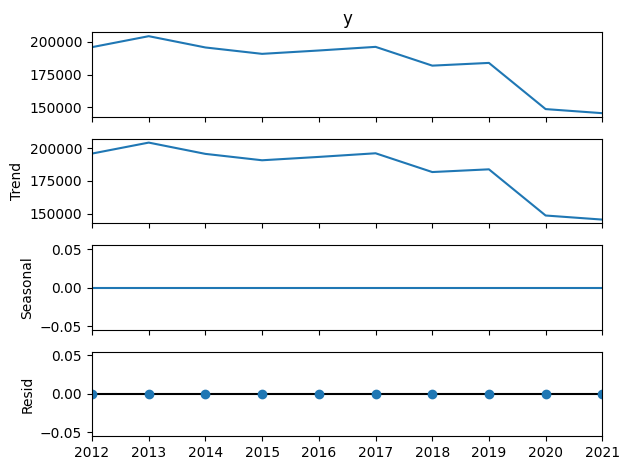

In [1]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_PN['y'], model='additive')
fig = decomposition.plot()
plt.show()


In [1]:
# Cross validation for MLP Model
X = df_train.drop(['services', 'y'], axis=1)
y = df_train['y']

scorer = make_scorer(r2_score)
cv_scores = cross_val_score(mlp_model, X, y, cv=3, scoring=scorer)

log.info("Scores de Validation Croisée: %s", cv_scores)
log.info("RMSE Moyen: %s", np.mean(cv_scores))

[INFO] 2023-12-10 20:45:06,027 __main__.<module>() 8: Scores de Validation Croisée: [0.04297264 0.97128725 0.99611503]
[INFO] 2023-12-10 20:45:06,030 __main__.<module>() 9: RMSE Moyen: 0.670124977179428


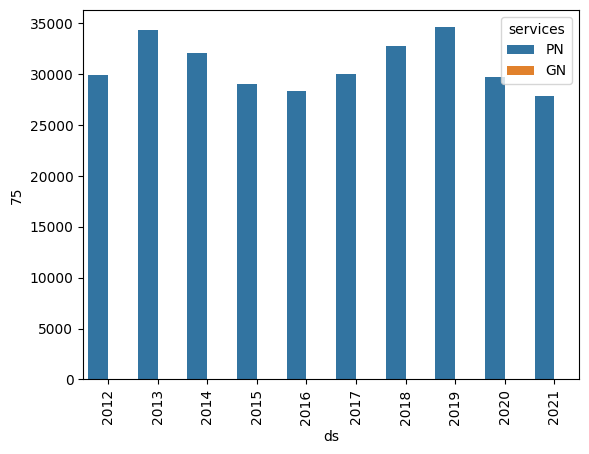

In [1]:
# Paris crime evolution
sns.barplot(data=df, x="ds", y="75", hue="services", order=sorted(df["ds"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
arma_rmse, r2_arma = 0, 0
sma_rmse, r2_sma = 0, 0
ema_rmse, r2_ema = 0, 0
mlp_rmse, r2_mlp = 0, 0
geo_def_pred = gpd.read_file(Constant.GEOJSON_FILE)
geo_def_pred['Services PN 2021'] = np.int_

for dept in tqdm(df_train.drop(['services', 'y'], axis=1).columns) :
    y = df_train[dept].astype(int)
    arima_model = ARIMA(y, order = (1, 2, 2))
    arima_model = arima_model.fit()

    # ARIMA Predictions
    y_pred_arima = arima_model.get_forecast(len(df_test.index))
    y_pred_df_arima = y_pred_arima.conf_int(alpha = 0.05) 
    y_pred_df_arima["Predictions"] = arima_model.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])

    # Simple Moving Average (SMA)
    sma_model = SimpleExpSmoothing(df_train[dept].astype(int)).fit()
    y_pred_sma = sma_model.forecast(len(df_test))

    # Exponential Moving Average (EMA)
    ema_model = ExponentialSmoothing(df_train[dept].astype(int)).fit()
    y_pred_ema = ema_model.forecast(len(df_test))

    # MLPRegressor
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
    mlp_model.fit(df_train.drop(['services'], axis=1), df_train['y'])
    y_pred_mlp = mlp_model.predict(df_test.drop(['services'], axis=1))

    # metrics
    arma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_df_arima["Predictions"]))
    r2_arma += r2_score(df_test["y"].values, y_pred_df_arima["Predictions"])

    sma_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_sma))
    r2_sma += r2_score(df_test["y"].values, y_pred_sma)

    ema_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_ema))
    r2_ema += r2_score(df_test["y"].values, y_pred_ema)

    mlp_rmse += np.sqrt(mean_squared_error(df_test[dept].values, y_pred_mlp))
    r2_mlp += r2_score(df_test["y"].values, y_pred_mlp)
    
    geo_def_pred.loc[geo_def_pred.index[geo_def_pred['code'] == dept], 'Services PN 2021'] = y_pred_ema[0]

log.info("ARIMA RMSE: %s, ARIMA R²: %s", arma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_arma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("SMA RMSE: %s, SMA R²: %s", sma_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_sma / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("EMA RMSE: %s, EMA R²: %s", ema_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_ema / len(df_train.drop(['services', 'y'], axis=1).columns))
log.info("MLP RMSE: %s, MLP R²: %s", mlp_rmse / len(df_train.drop(['services', 'y'], axis=1).columns), r2_mlp / len(df_train.drop(['services', 'y'], axis=1).columns))

100%|██████████| 105/105 [00:31<00:00,  3.35it/s]

[INFO] 2023-12-10 20:45:39,866 __main__.<module>() 46: ARIMA RMSE: 352.2508385611088, ARIMA R²: nan
[INFO] 2023-12-10 20:45:39,873 __main__.<module>() 47: SMA RMSE: 255.62015791944623, SMA R²: nan
[INFO] 2023-12-10 20:45:39,879 __main__.<module>() 48: EMA RMSE: 263.85305161176433, EMA R²: nan
[INFO] 2023-12-10 20:45:39,883 __main__.<module>() 49: MLP RMSE: 257201.60652566404, MLP R²: nan


In [1]:
geo_def_pred['Services PN 2021'] /= geo_def_pred['Services PN 2021'].max()

<Axes: >

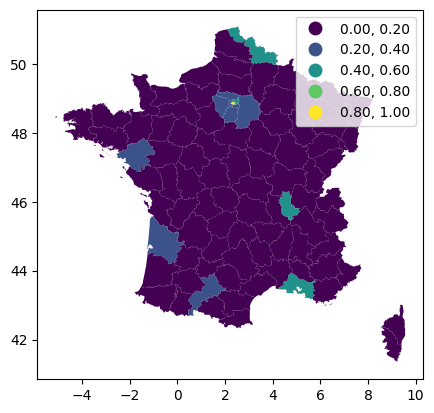

In [1]:
geo_def_pred.plot(column='Services PN 2021', legend=True, scheme="prettybreaks")

In [1]:
log.debug('End')
log.info('Finished successfully in %.2fs', time.time() - starting_time)

[INFO] 2023-12-10 20:45:40,790 __main__.<module>() 2: Finished successfully in 54.22s
